In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient
import os

# 1. 폰트 설정 및 라이브러리 import

In [2]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client, 
)


# 2. Influx DB 

In [4]:
# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()


# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["location"] == "입구")
  |> filter(fn: (r) => r["type"] == "activity" or r["type"] == "co2" or r["type"] == "humidity" or r["type"] == "infrared_and_visible" or r["type"] == "temperature" or r["type"] == "tvoc" or r["type"] == "pressure" or r["type"] == "infrared" or r["type"] == "illumination")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["location"] == "입구")
  |> filter(fn: (r) => r["type"] == "activity" or r["type"] == "co2" or r["type"] == "humidity" or r["type"] == "infrared_and_visible" or r["type"] == "temperature" or r["type"] == "tvoc" or r["type"] == "pressure" or r["type"] == "infrared" or r["type"] == "illumination")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-24 02:30:00+00:00,0,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,11.500000,value,sensor,입구,activity
2025-04-24 02:35:00+00:00,1,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,12.600000,value,sensor,입구,activity
2025-04-24 02:40:00+00:00,2,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,20.250000,value,sensor,입구,activity
2025-04-24 04:25:00+00:00,3,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,4.250000,value,sensor,입구,activity
2025-04-24 04:30:00+00:00,4,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,6.333333,value,sensor,입구,activity


데이터 크기: (2412, 10)


In [10]:
pivot_df = df.pivot_table(
    index=['time', 'location'],
    columns='type',
    values='_value'
).reset_index()

pivot_df = pivot_df.set_index('time')

# 인덱스 초기화하여 중복 문제 해결
pivot_df_reset = pivot_df.reset_index(drop=False).copy()

# 분석할 환경 변수 목록
env_vars = ['temperature', 'humidity', 'co2', 'tvoc', 'pressure']
available_vars = [var for var in env_vars if var in pivot_df_reset.columns]

## 온도와 활동량

활동량과 온도의 상관계수: -0.1688
해석: 활동량과 온도 사이에는 음의 약한 상관관계가 있습니다.
이는 활동량이 증가할수록 온도는 감소함을 의미합니다.


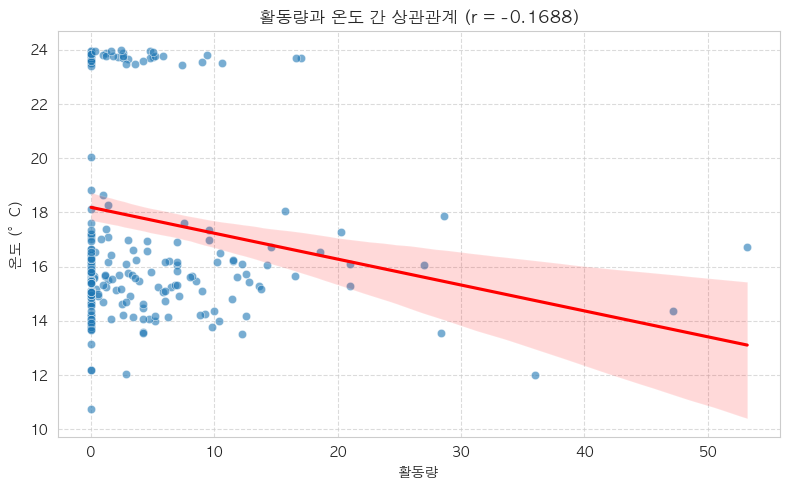

In [11]:
# 온도와 활동량 상관관계 분석
corr_temp_activity = pivot_df_reset[['activity', 'temperature']].corr().iloc[0, 1]
print(f"활동량과 온도의 상관계수: {corr_temp_activity:.4f}")

# 상관관계 해석
if abs(corr_temp_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_temp_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_temp_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 온도 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 온도도 증가' if corr_temp_activity > 0 else '증가할수록 온도는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='temperature', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='temperature', scatter=False, color='red')
plt.title(f'활동량과 온도 간 상관관계 (r = {corr_temp_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('온도 (°C)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_temperature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 습도와 활동량

활동량과 습도의 상관계수: 0.2262
해석: 활동량과 습도 사이에는 양의 약한 상관관계가 있습니다.
이는 활동량이 증가할수록 습도도 증가함을 의미합니다.


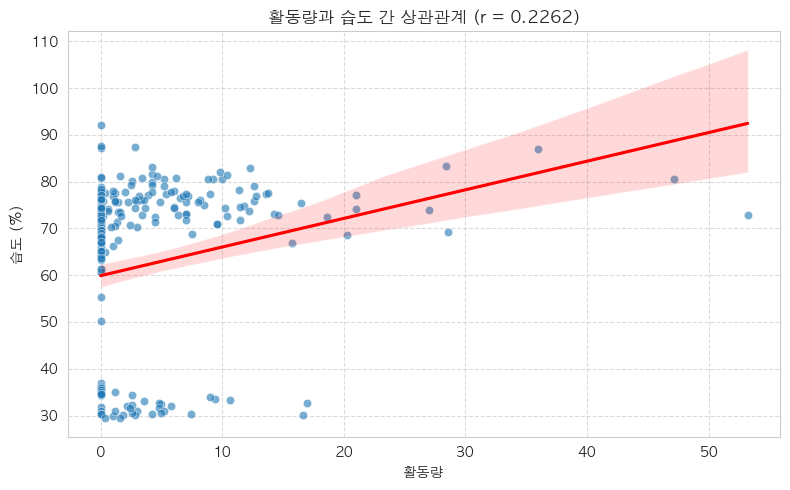

In [12]:
# 습도와 활동량 상관관계 분석
corr_humidity_activity = pivot_df_reset[['activity', 'humidity']].corr().iloc[0, 1]
print(f"활동량과 습도의 상관계수: {corr_humidity_activity:.4f}")

# 상관관계 해석
if abs(corr_humidity_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_humidity_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_humidity_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 습도 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 습도도 증가' if corr_humidity_activity > 0 else '증가할수록 습도는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='humidity', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='humidity', scatter=False, color='red')
plt.title(f'활동량과 습도 간 상관관계 (r = {corr_humidity_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('습도 (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_humidity_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## Co2 활동량

활동량과 CO₂의 상관계수: 0.5648
해석: 활동량과 CO₂ 사이에는 양의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 CO₂도 증가함을 의미합니다.


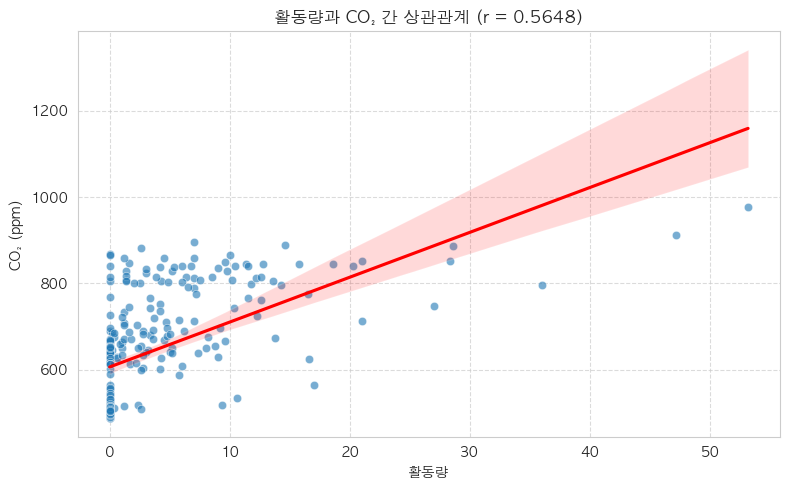

In [13]:
# CO₂와 활동량 상관관계 분석
corr_co2_activity = pivot_df_reset[['activity', 'co2']].corr().iloc[0, 1]
print(f"활동량과 CO₂의 상관계수: {corr_co2_activity:.4f}")

# 상관관계 해석
if abs(corr_co2_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_co2_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_co2_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 CO₂ 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 CO₂도 증가' if corr_co2_activity > 0 else '증가할수록 CO₂는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='co2', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='co2', scatter=False, color='red')
plt.title(f'활동량과 CO₂ 간 상관관계 (r = {corr_co2_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('CO₂ (ppm)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_co2_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## TVOC : 총 휘발성 유기 화합물(Total Volatile Organic Compounds)과 활동량

활동량과 TVOC의 상관계수: 0.3676
해석: 활동량과 TVOC 사이에는 양의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 TVOC도 증가함을 의미합니다.


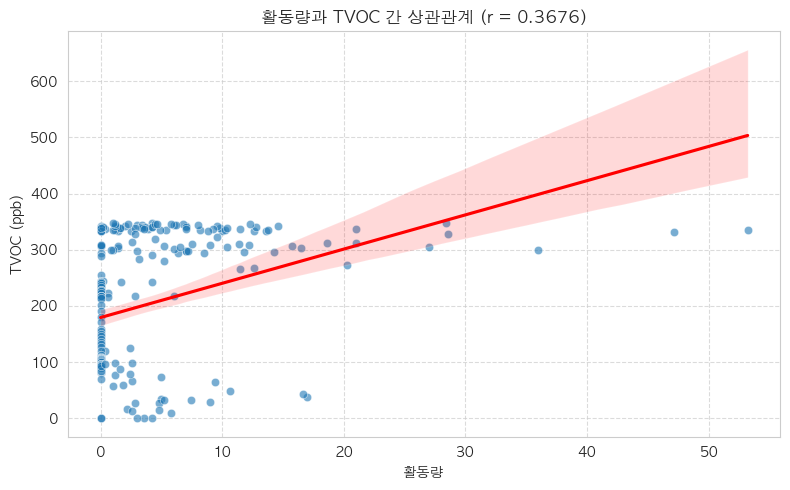

In [14]:
# TVOC와 활동량 상관관계 분석
corr_tvoc_activity = pivot_df_reset[['activity', 'tvoc']].corr().iloc[0, 1]
print(f"활동량과 TVOC의 상관계수: {corr_tvoc_activity:.4f}")

# 상관관계 해석
if abs(corr_tvoc_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_tvoc_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_tvoc_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 TVOC 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 TVOC도 증가' if corr_tvoc_activity > 0 else '증가할수록 TVOC는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='tvoc', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='tvoc', scatter=False, color='red')
plt.title(f'활동량과 TVOC 간 상관관계 (r = {corr_tvoc_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('TVOC (ppb)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_tvoc_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 압력과 활동량

활동량과 압력의 상관계수: -0.3450
해석: 활동량과 압력 사이에는 음의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 압력은 감소함을 의미합니다.


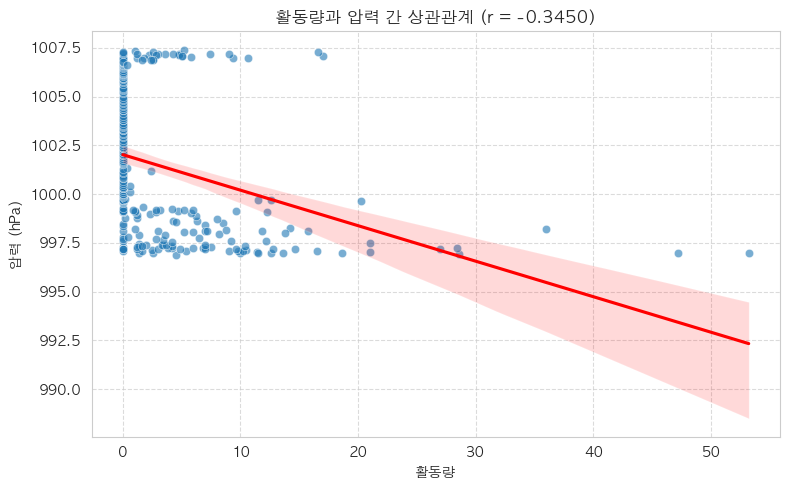

In [15]:
# 압력과 활동량 상관관계 분석
corr_pressure_activity = pivot_df_reset[['activity', 'pressure']].corr().iloc[0, 1]
print(f"활동량과 압력의 상관계수: {corr_pressure_activity:.4f}")

# 상관관계 해석
if abs(corr_pressure_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_pressure_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_pressure_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 압력 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 압력도 증가' if corr_pressure_activity > 0 else '증가할수록 압력은 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='pressure', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='pressure', scatter=False, color='red')
plt.title(f'활동량과 압력 간 상관관계 (r = {corr_pressure_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('압력 (hPa)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_pressure_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
from sklearn.decomposition import PCA

variables = ['co2', 'tvoc', 'activity', 'pressure']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df_reset[variables])

In [21]:
pca_result

array([[ 134.3824974 ,  -32.90032782],
       [ 130.75047491,  -28.01483529],
       [ 194.94567164,  -75.75027087],
       [ 180.60289131,  -38.64509317],
       [ 189.90810777,  -43.5025825 ],
       [ 190.45063178,  -43.01475592],
       [ 189.55269034,  -37.88292099],
       [ 176.71522349,  -29.09464786],
       [ 180.21864696,  -27.55319816],
       [ 172.14523891,  -23.63545541],
       [ 162.16184158,  -14.57080223],
       [ 179.41546933,  -30.94322091],
       [ 198.49605506,  -45.62729829],
       [ 219.45450822,  -53.56208868],
       [ 208.28673109,  -43.0757022 ],
       [ 185.78074968,  -29.23833545],
       [ 189.68934461,  -30.71421194],
       [ 190.48970161,  -28.19898166],
       [ 178.57654681,  -20.05388669],
       [ 196.84908663,  -30.77843378],
       [ 207.46577243,  -42.26541578],
       [ 199.67574108,  -31.96635358],
       [ 195.04362606,  -26.71570493],
       [ 162.29665915,   -2.3551219 ],
       [ 145.07990215,    8.70103213],
       [ 164.42179929,  -

## 시간대별 Co2/TVOC 패턴 분석

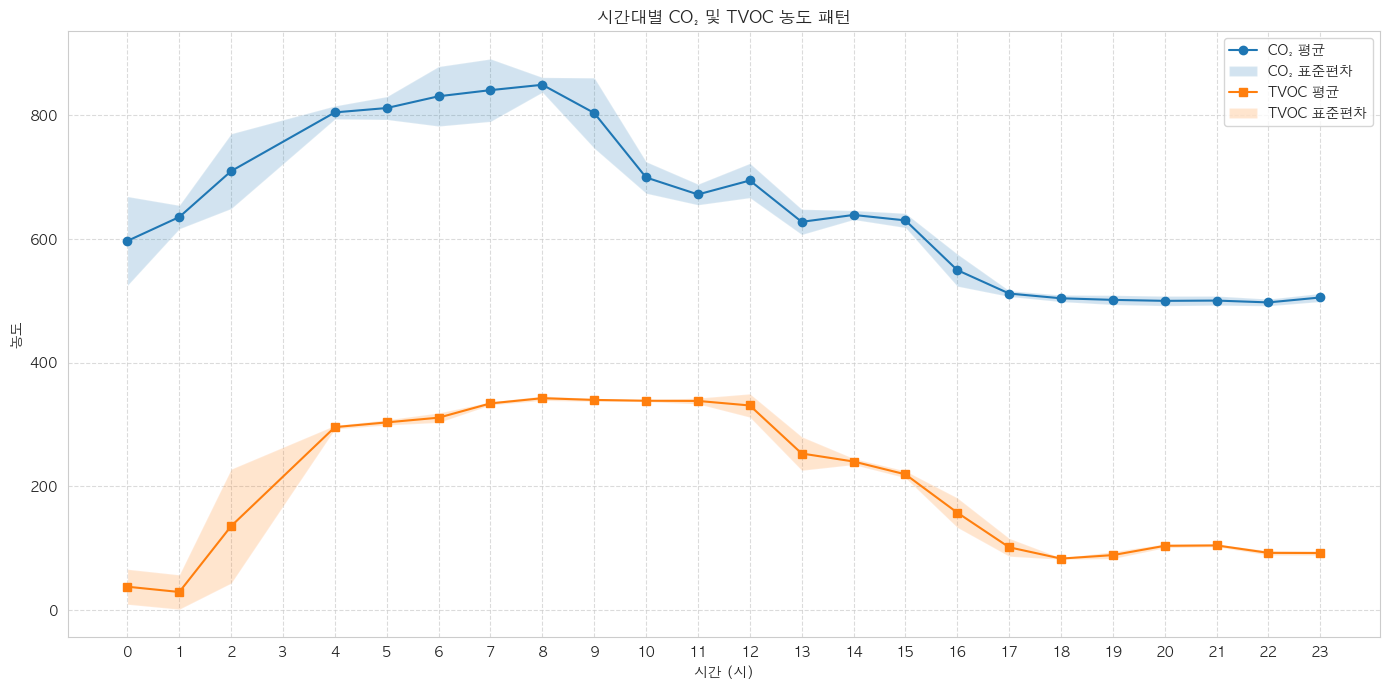

In [22]:
# 시간대별 평균 농도 계산
hourly_stats = pivot_df_reset.groupby('hour')[['co2', 'tvoc']].agg(['mean', 'std', 'max'])

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(hourly_stats['co2']['mean'], label='CO₂ 평균', marker='o')
plt.fill_between(hourly_stats.index, 
                hourly_stats['co2']['mean'] - hourly_stats['co2']['std'], 
                hourly_stats['co2']['mean'] + hourly_stats['co2']['std'], 
                alpha=0.2, label='CO₂ 표준편차')

plt.plot(hourly_stats['tvoc']['mean'], label='TVOC 평균', marker='s')
plt.fill_between(hourly_stats.index, 
                hourly_stats['tvoc']['mean'] - hourly_stats['tvoc']['std'], 
                hourly_stats['tvoc']['mean'] + hourly_stats['tvoc']['std'], 
                alpha=0.2, label='TVOC 표준편차')

plt.title('시간대별 CO₂ 및 TVOC 농도 패턴')
plt.xlabel('시간 (시)')
plt.ylabel('농도')
plt.xticks(range(0,24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('img/time_co2_tvoc_pattern.png', dpi=300)
plt.show()


## CO2 임계값 초과분석

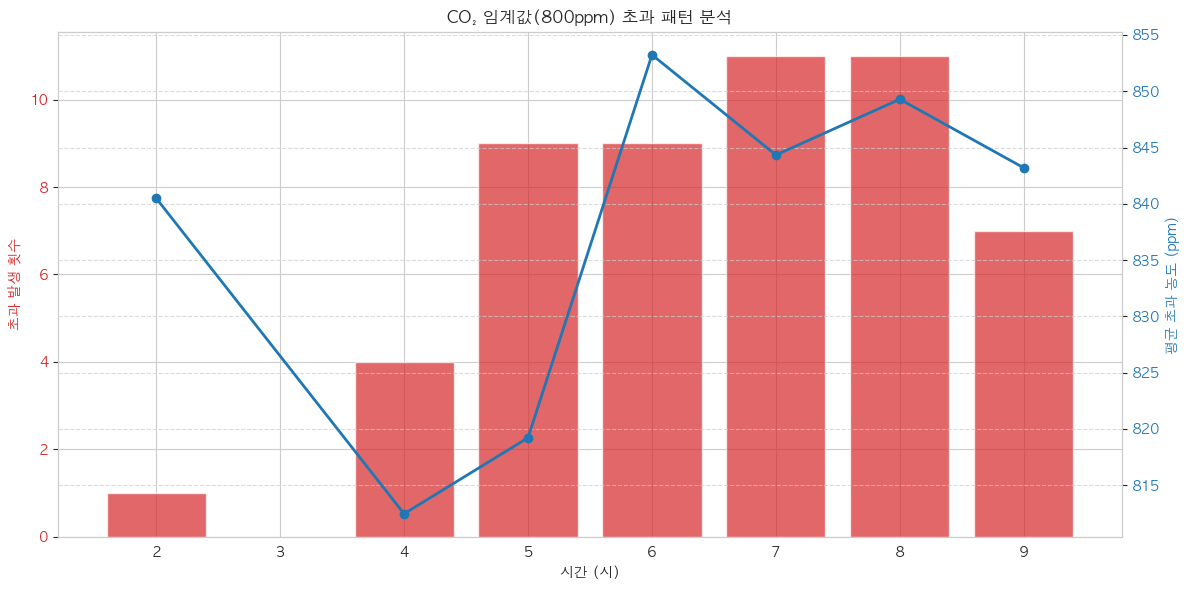

전체 데이터 중 임계값 초과 비율: 19.40%


In [23]:
co2_threshold = 800  # ppm

# 임계값 초과 분석
exceed_df = pivot_df_reset[pivot_df_reset['co2'] > co2_threshold]
exceed_stats = exceed_df.groupby('hour')['co2'].agg(['count', 'mean'])

# 시각화
fig, ax1 = plt.subplots(figsize=(12,6))
color = 'tab:red'
ax1.set_xlabel('시간 (시)')
ax1.set_ylabel('초과 발생 횟수', color=color)
ax1.bar(exceed_stats.index, exceed_stats['count'], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(0,24))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('평균 초과 농도 (ppm)', color=color)
ax2.plot(exceed_stats.index, exceed_stats['mean'], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'CO₂ 임계값({co2_threshold}ppm) 초과 패턴 분석')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/co2_threshold_analysis.png', dpi=300)
plt.show()

print(f"전체 데이터 중 임계값 초과 비율: {len(exceed_df)/len(pivot_df_reset)*100:.2f}%")


## PCA를 이용한 다변량 분석

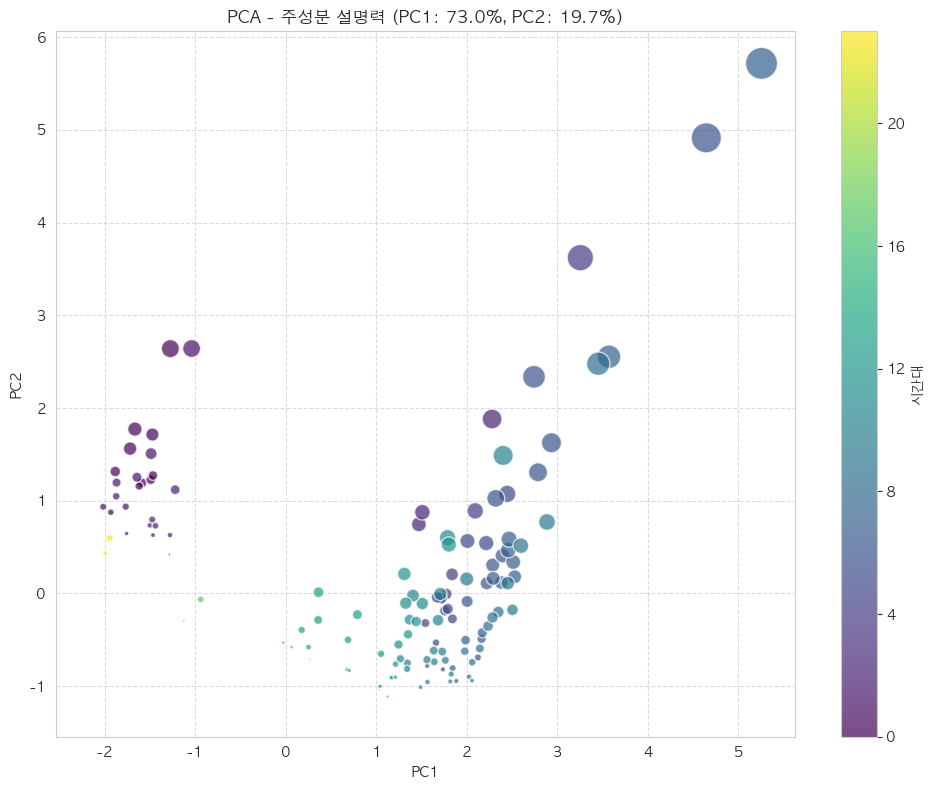

In [26]:
from sklearn.preprocessing import StandardScaler

# 표준화 필수 (PCA 특성)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df_reset[['co2', 'tvoc', 'activity', 'pressure']])

# PCA 수행 (주성분 2개)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10,8))

# 1. Matplotlib scatterplot 사용 (mappable 반환)
scatter = plt.scatter(
    x=pca_result[:,0], 
    y=pca_result[:,1], 
    c=pivot_df_reset['hour'], 
    cmap='viridis',
    s=pivot_df_reset['activity']*10,  # 활동량에 따른 크기 조정
    alpha=0.7,
    edgecolors='w'
)

# 2. Colorbar 설정
cbar = plt.colorbar(scatter, label='시간대')
cbar.set_ticks(range(0,24,4))  # 4시간 간격 틱 설정

# 3. 주성분 설명력 표시
plt.title(f'PCA - 주성분 설명력 (PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/pca_analysis.png', dpi=300)
plt.show()





| **스케일러** | **장점** | **단점** | **PCA 적합성** |
| --- | --- | --- | --- |
| **StandardScaler** | 이상치 영향 적음, 분산 보존 | 정규분포 가정 없음 | ⭐️ 최적 |
| MinMaxScaler | 고정된 범위(예: 0~1) | 이상치에 매우 취약 | ❌ 부적합 |
| RobustScaler | 이상치 강건함 | 중앙값 기반으로 분산 왜곡 | △ 보통 |

## TVOC 농도 위험도 평가

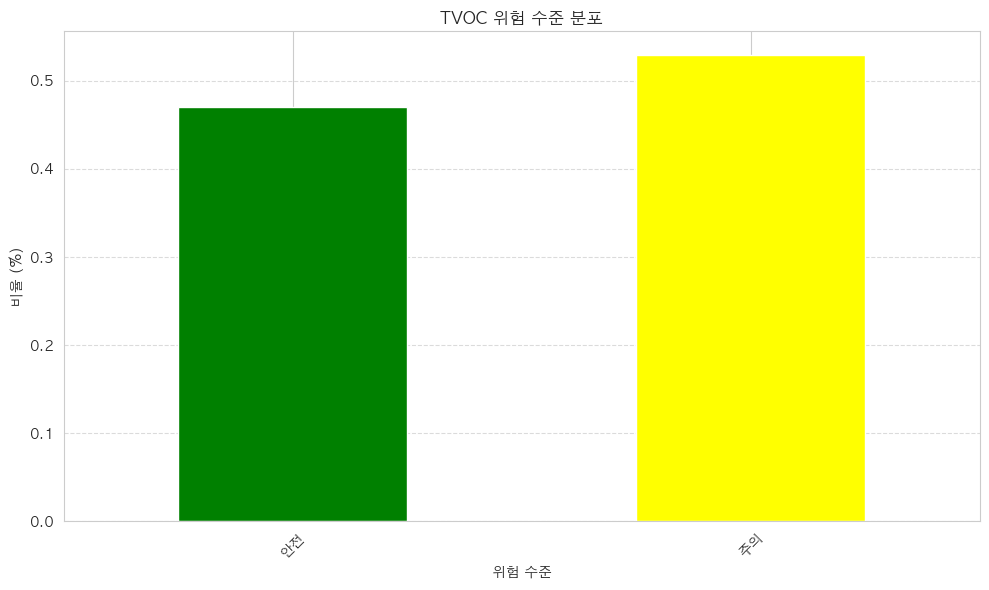

In [25]:
# WHO 기준 적용
tvoc_thresholds = {
    '안전': 200,   # ppb
    '주의': 500,
    '위험': 1000
}

# 위험 수준 분류
conditions = [
    (pivot_df_reset['tvoc'] <= tvoc_thresholds['안전']),
    (pivot_df_reset['tvoc'] <= tvoc_thresholds['주의']),
    (pivot_df_reset['tvoc'] <= tvoc_thresholds['위험']),
    (pivot_df_reset['tvoc'] > tvoc_thresholds['위험'])
]

choices = ['안전', '주의', '위험', '매우 위험']
pivot_df_reset['tvoc_risk'] = np.select(conditions, choices, default='기타')

# 위험 수준별 시간 비율 계산
risk_dist = pivot_df_reset['tvoc_risk'].value_counts(normalize=True).sort_index()

# 시각화
plt.figure(figsize=(10,6))
risk_dist.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('TVOC 위험 수준 분포')
plt.xlabel('위험 수준')
plt.ylabel('비율 (%)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/tvoc_risk_assessment.png', dpi=300)
plt.show()
